**Importing the required libraries**

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.activations import gelu
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, InputLayer

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score


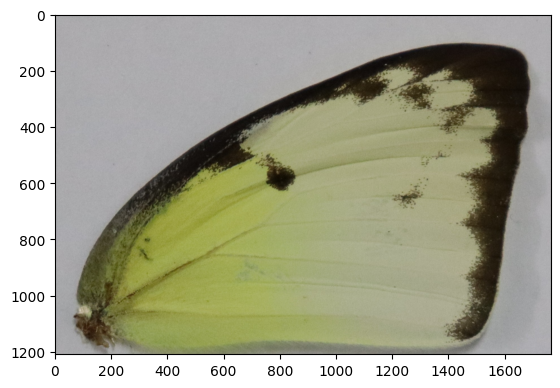

In [2]:
base_dir = os.path.join("data", "female")
file_name = "female_146.jpg"
file_path = os.path.join(base_dir, file_name)

if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {file_path}")

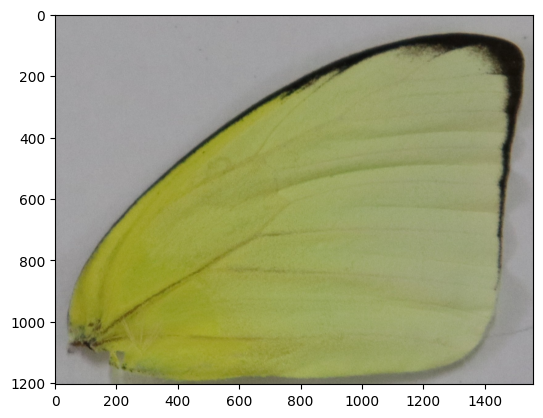

In [3]:
base_dir = os.path.join("data", "male")
file_name = "male_189.jpg"
file_path = os.path.join(base_dir, file_name)

if os.path.exists(file_path):
    img = mpimg.imread(file_path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print(f"File not found: {file_path}")

**Load and Preprocess Images**

In [4]:
# Set paths
train_dir = 'split-data/train'
val_dir = 'split-data/val'

In [5]:
# Image parameters
img_size = 256
batch_size = 8
num_classes = 1

**Data Augmentation**

In [6]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 320 images belonging to 2 classes.


In [9]:
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 80 images belonging to 2 classes.


In [10]:
# Example to check a single batch
x_batch, y_batch = next(train_gen)
print(x_batch.shape, y_batch.shape)
print(y_batch)

(8, 256, 256, 3) (8,)
[0. 1. 1. 1. 1. 0. 1. 1.]


In [11]:
# Instantiate metrics once
auc_metric = tf.keras.metrics.AUC(multi_label=True, from_logits=False)
recall_metric = tf.keras.metrics.Recall()
precision_metric = tf.keras.metrics.Precision()

# F1 Score
def f1_score_m(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)

    precision = precision_metric(y_true, y_pred_labels)
    recall = recall_metric(y_true, y_pred_labels)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# AUC Score
def auc_m(y_true, y_pred):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
    return auc_metric(y_true_one_hot, y_pred)

# Recall Score
def recall_m(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    return recall_metric(y_true, y_pred_labels)


**Define CNN Model**

In [12]:
# Step 1: Reset TensorFlow graph (avoids "AlreadyExistsError")
tf.keras.backend.clear_session()

# Step 2: Force garbage collection to free memory
import gc
gc.collect()

# Step 3: Reinitialize generators (to avoid duplicate references)
train_gen.reset()
val_gen.reset()


# Model Architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(2, activation='softmax')
])


d:\Dissertation-Project\Projects\code\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile Model**

In [13]:
# Compile the model with additional metrics: AUC, Recall, and F1 Score
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', auc_m, recall_m, f1_score_m])

**Callbacks**

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)
checkpoint = ModelCheckpoint("cnn.h5", monitor='val_loss', save_best_only=True, verbose=1)

**Train the Model**

In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

d:\Dissertation-Project\Projects\code\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6858 - auc_m: 0.5291 - f1_score_m: 0.4735 - loss: 11.7397 - recall_m: 0.4503
Epoch 1: val_loss improved from inf to 1.96149, saving model to cnn.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 698ms/step - accuracy: 0.6875 - auc_m: 0.5328 - f1_score_m: 0.4778 - loss: 11.7701 - recall_m: 0.4549 - val_accuracy: 0.6250 - val_auc_m: 0.7695 - val_f1_score_m: 0.7401 - val_loss: 1.9615 - val_recall_m: 0.7414 - learning_rate: 0.0010
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.7955 - auc_m: 0.7616 - f1_score_m: 0.7258 - loss: 8.2892 - recall_m: 0.6921
Epoch 2: val_loss did not improve from 1.96149
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 650ms/step - accuracy: 0.7958 - auc_m: 0.7619 - f1_score_m: 0.7261 - loss: 8.2901 - recall_m: 0.6924 - val_accuracy: 0.5000 - val_auc_m: 0.7547 - val_f1_score_m: 0.7328 - val_loss: 14.8099 - val_recall_m: 0.7429 - learning_rate: 0.0010
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8353 - auc_m: 0.7659 - f1_score_m: 0.7488 - loss: 8.0169 - recall_m: 0.7665
Epoch 3: val_loss did not improve from 1.96149
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 649ms/step - accuracy: 0.8354 - auc_m: 0.7661 - f1_score_

**Results**

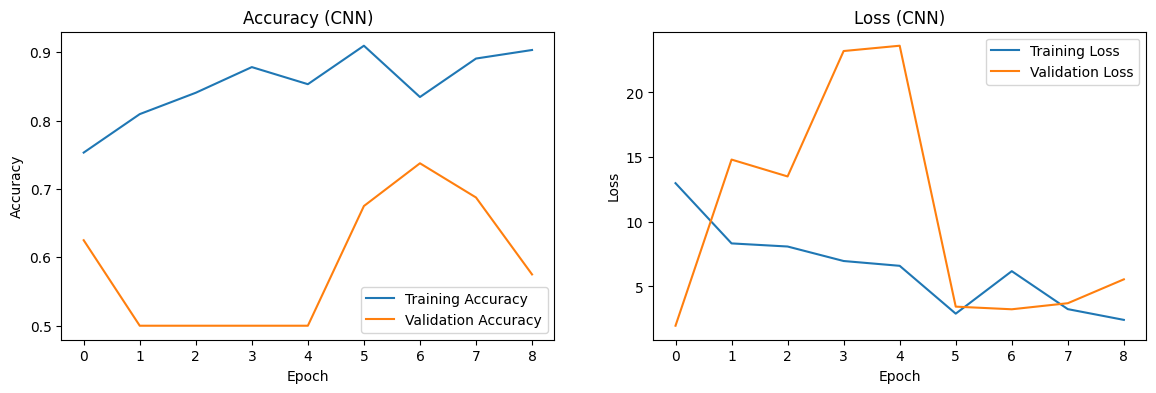

In [26]:
import matplotlib.pyplot as plt

# Ploting training & validation accuracy
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Ploting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
              precision    recall  f1-score   support

      female       0.58      0.93      0.71        40
        male       0.81      0.33      0.46        40

    accuracy                           0.62        80
   macro avg       0.70      0.62      0.59        80
weighted avg       0.70      0.62      0.59        80



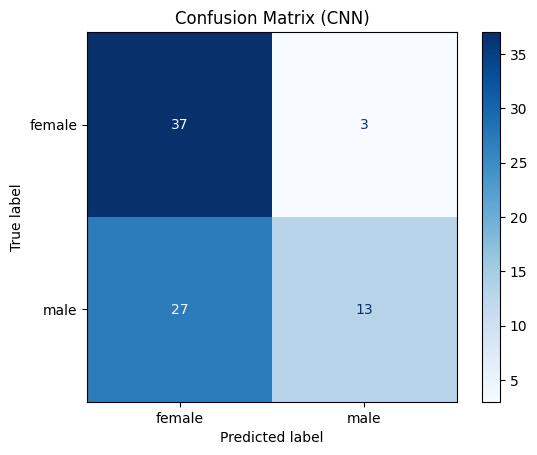

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_gen.classes

# Report
print(classification_report(y_true, y_pred, target_names=['female', 'male']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['female', 'male'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (CNN)')
plt.show()

In [18]:
# Get predicted probabilities
y_pred_probs = model.predict(val_gen)
# Extract probability for class 1 (male)
y_pred_class1_probs = y_pred_probs[:, 1]

# AUC-ROC
auc_score = roc_auc_score(y_true, y_pred_class1_probs)
print(f"AUC-ROC Score: {auc_score:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
AUC-ROC Score: 0.7131


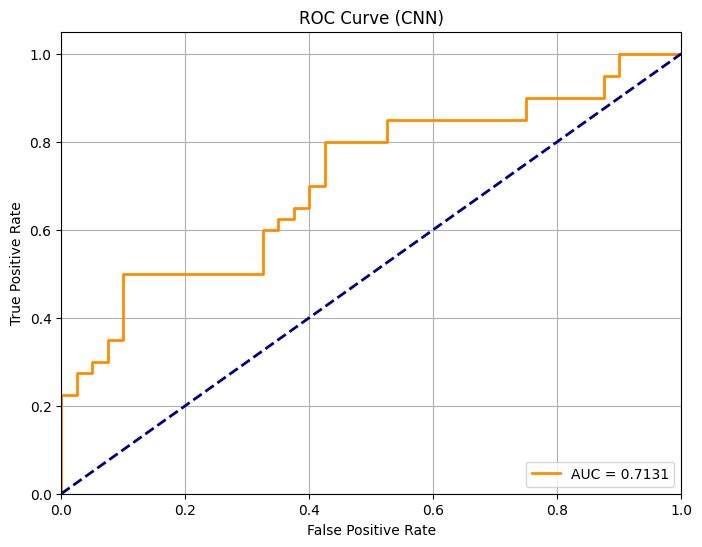

In [19]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_class1_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (CNN)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

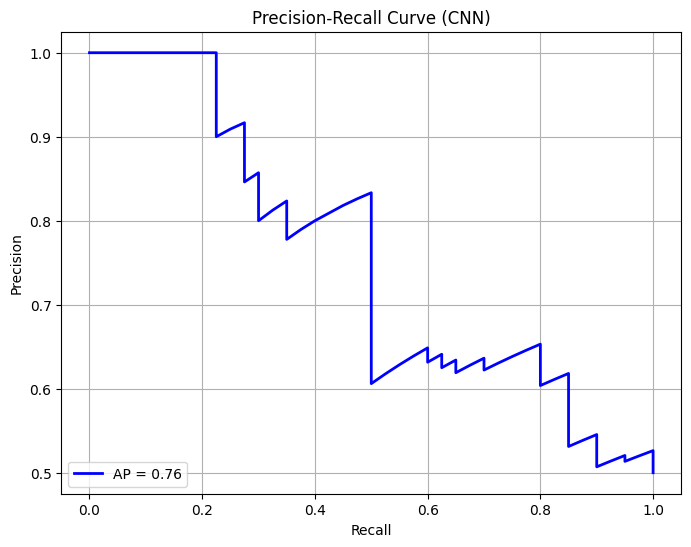

In [20]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_class1_probs)
ap_score = average_precision_score(y_true, y_pred_class1_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CNN)')
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,543,880 (169.92 MB)

 Trainable params: 14,847,810 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 29,695,622 (113.28 MB)